In [36]:
import os
import json
import numpy as np
import nibabel as nib

from glob import glob

In [37]:
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
fmriprep_dir = os.path.join(project_dir, 'derivatives', 'fmriprep_noSDC')

bidsroot = os.path.join(project_dir, 'data_bids_noIntendedFor')
deriv_dir = os.path.join(bidsroot, 'derivatives')

nilearn_dir = os.path.join(deriv_dir, 'nilearn')
print(nilearn_dir)

task_list = ['tonecat']

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn


In [38]:
sub_list_mand = ['FLT01', 'FLT03', 'FLT05', 'FLT07', 'FLT08', 'FLT10', ] # 

sub_list_nman = ['FLT02', 'FLT04', 'FLT06', 'FLT09', 'FLT11', 'FLT12', 'FLT13', ]

sub_list = sub_list_mand + sub_list_nman

## generate anatomical masks

In [39]:
roi_dict_MNI_dseg = {'L-Caud': 35, 'L-Put': 36, 'L-HG': 189, 'L-PP': 187, 'L-PT': 191, 'L-STGa': 117, 'L-STGp': 119, 'L-ParsOp': 111, 'L-ParsTri': 109, 
                     'R-Caud': 46, 'R-Put': 47, 'R-HG': 190, 'R-PP': 188, 'R-PT': 192, 'R-STGa': 118, 'R-STGp': 120, 'R-ParsOp': 112, 'R-ParsTri': 110, }

In [40]:
roi_dict_T1w_aseg = {'L-VentralDC': 28, 'L-Caud': 11, 'L-Put': 12, 'L-HG': 1034, 'L-STG': 1030, 'L-ParsOp': 1018, 'L-ParsTri': 1020, 'L-SFG': 1028, 'Brainstem': 16, 
                     'R-VentralDC': 60, 'R-Caud': 50, 'R-Put': 51, 'R-HG': 2034, 'R-STG': 2030, 'R-ParsOp': 2018, 'R-ParsTri': 2020, 'R-SFG': 2028, 'CSF': 24}

In [41]:
roi_dict_MNI_sg_subcort = {'L-CN': 1, 'L-SOC': 3, 'L-IC': 5, 'L-MGN': 7, 
                           'R-CN': 2, 'R-SOC': 4, 'R-IC': 6, 'R-MGN': 8, }

In [9]:
roi_dict = roi_dict_MNI_sg_subcort # roi_dict_MNI_dseg # roi_dict_T1w_aseg # 

In [21]:
def generate_mask(sub_id, zmap_example_fpath, atlas_fpath, labelnum, labelname, out_dir, spacelabel):
    from nilearn.image import resample_to_img
    
    atlas_img = nib.load(atlas_fpath)
    atlas_data = atlas_img.get_fdata()
    atlas_affine = atlas_img.affine
    
    mask_data = np.zeros((atlas_data.shape))
    mask_data[np.where(atlas_data == labelnum)] = 1

    mask_img = nib.Nifti1Image(mask_data, atlas_affine)

    mask_func_img = resample_to_img(mask_img, zmap_example_fpath, interpolation='nearest')
    
    out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, labelname))
    nib.save(mask_func_img, out_fpath)
    
    return out_fpath

In [ ]:
'''
fwhm_sub = 0
space_label = 'MNI152NLin2009cAsym' # 'T1w' # 'MNI152NLin2009cAsym' #
atlas_label =  'subcort_aud' # 'carpet_dseg' # 'aparc'

for mx, sub_id in enumerate(sub_list):
    print(sub_id)
    
    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                               'level-1_fwhm-%.02f'%fwhm_sub, 
                                               'sub-%s_space-%s'%(sub_id, space_label))    
    zmap_example_fpath = z_maps = sorted(glob(nilearn_sub_dir+'/trial_models/run*/*di*beta.nii.gz'))[0]
    
    if space_label == 'T1w' and atlas_label == 'aparc': 
        atlas_fpath = os.path.join(fmriprep_dir,'sub-%s/anat'%sub_id,
                                    'sub-%s_desc-%saseg_dseg.nii.gz'%(sub_id, atlas_label))


        sub_mask_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 
                                    'space-%s'%space_label, 'masks-aparc') 
    elif space_label == 'MNI152NLin2009cAsym' and atlas_label == 'carpet_dseg': 
        atlas_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/',
                                   'reference/', #tpl-MNI152NLin2009cAsym/',
                                   'tpl-MNI152NLin2009cAsym_res-01_desc-carpet_dseg.nii.gz')  
        sub_mask_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 
                                    'space-%s'%space_label, 'masks-dseg')  
    elif space_label == 'MNI152NLin2009cAsym' and atlas_label == 'subcort_aud':
        atlas_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/',
                                   'reference/MNI_space/atlases',
                                   'sub-bigbrain_MNI_conjunction_rois.nii.gz')
        sub_mask_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 
                                    'space-%s'%space_label, 'masks-subcort-aud')  
    else:
        print('mismatch between space label and atlas label')
    if not os.path.exists(sub_mask_dir):
        os.makedirs(sub_mask_dir)
                
    for key, value in roi_dict.items():
        print('generating {} mask file'.format(key))
        mask_fpath = generate_mask(sub_id, zmap_example_fpath, atlas_fpath, 
                                   value, key, sub_mask_dir, space_label)
'''

## Define data and labels

In [22]:
def create_labels(stat_maps):
    import os
    from glob import glob
    from numpy.random import shuffle
    from copy import copy
    
    # 16 stimulus decoding
    #conditions_all = [os.path.basename(x)[-31:-18] for x in stat_maps] 
    conditions_all = ['_'.join(os.path.basename(x).split('_')[5:8]) for x in (stat_maps)]
    #print('all events: ', conditions_all[:10])

    # 4-category decoding
    conditions_tone = [os.path.basename(x).split('_')[5] for x in (stat_maps)]

    conditions_talker = [os.path.basename(x).split('_')[6] for x in (stat_maps)]
    
    # shuffled conditions
    conditions_shuffled = copy(conditions_tone)
    shuffle(conditions_shuffled)

    return conditions_tone, conditions_talker, conditions_all, conditions_shuffled

## Decoding

### scikit learn

In [23]:
def mask_fmri(fmri_niimgs, mask_filename, fwhm):
    from nilearn.maskers import NiftiMasker
    masker = NiftiMasker(mask_img=mask_filename, #runs=session_label,
                         smoothing_fwhm=fwhm, standardize=True,
                         memory="nilearn_cache", memory_level=1)
    fmri_masked = masker.fit_transform(fmri_niimgs)
    return fmri_masked, masker

In [24]:
def sub_region_svc(sub_id, mask_fpath, stat_maps, cv, fwhm=1.5, space_label='T1w'):
    from sklearn.svm import SVC
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import permutation_test_score

    #print(sub_id)
    #print(os.path.basename(mask_fpath))
          
    conditions_tone, conditions_talker, conditions_all, conditions_shuffled = create_labels(stat_maps)

    # extract beta values from stat maps for given region of interest
    fmri_masked, masker = mask_fmri(stat_maps, mask_fpath, fwhm_sub)

    svc = SVC()

    tone_cv_scores = cross_val_score(svc, fmri_masked, conditions_tone, cv=cv)
    print("Tone SVC accuracy: {:.3f} with a standard deviation of {:.2f}".format(tone_cv_scores.mean(),tone_cv_scores.std()))

    talker_cv_scores = cross_val_score(svc, fmri_masked, conditions_talker, cv=cv)
    print("Talker SVC accuracy: {:.3f} with a standard deviation of {:.2f}".format(talker_cv_scores.mean(),talker_cv_scores.std()))

    null_cv_scores = permutation_test_score(svc, fmri_masked, conditions_tone, cv=cv, )[1]
    print("Permutation test score: {:.3f} with a standard deviation of {:.2f}".format(null_cv_scores.mean(),null_cv_scores.std()))
    
    #plot_confusion_matrix(fmri_masked, conditions_tone, mask_descrip, sub_id)
    #plot_confusion_matrix(fmri_masked, conditions_talker, mask_descrip, sub_id)
    
    return fmri_masked, tone_cv_scores, talker_cv_scores, null_cv_scores

#### Confusion matrix

In [25]:
def plot_confusion_matrix(X, y, mask_descrip, sub_id):
    import numpy as np
    import matplotlib.pyplot as plt

    from sklearn import svm, datasets
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import ConfusionMatrixDisplay

    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        random_state=0, stratify=y)

    # Run classifier, using a model that is too regularized (C too low) to see
    # the impact on the results
    classifier = svm.SVC(kernel="linear", ).fit(X_train, y_train)

    np.set_printoptions(precision=2)

    sub_title = 'sub-%s mask-%s'%(sub_id, mask_descrip)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", "true"),]
    #for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            #display_labels=class_names,
            cmap=plt.cm.Blues,
            #normalize='true', 
            )
    disp.ax_.set_title(sub_title)

    #print(title)
    #print(disp.confusion_matrix)

    #plt.show()
    
    return disp.confusion_matrix

#### Confusion matrices across regions

In [13]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

fwhm_sub = 1.5
space_label = 'MNI152NLin2009cAsym'#'T1w'
#roi_list = ['L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 
#            'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', ]

roi_list = list(roi_dict.keys())
#roi_list = ['L-Caud', 'L-Put', 'R-Caud', 'R-Put', ]
print(roi_list)
num_rois = len(roi_list)

['L-CN', 'L-SOC', 'L-IC', 'L-MGN', 'R-CN', 'R-SOC', 'R-IC', 'R-MGN']


In [ ]:
mand_conf_mat = []
nman_conf_mat = []
for sub_id in sub_list:
#for sub_id in ['FLT11', 'FLT12', 'FLT13']:
    print(sub_id)
    sub_conf_mat = []
    
    fig, axs = plt.subplots(nrows=2, ncols=round(num_rois/2), figsize=(num_rois,6), dpi=300)
    fig.suptitle(sub_id)
    
    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                       'level-1_fwhm-%.02f'%fwhm_sub, 
                                       'sub-%s_space-%s'%(sub_id, space_label))

    # run-specific stimulus beta maps
    stat_maps = sorted(glob(nilearn_sub_dir+'/stimulus_per_run'+'/run*/*di*nii.gz')) 
    print('# of stat maps: ', len(stat_maps))    
    #print(stat_maps)
    
    # generate condition labels based on filenames
    conditions_tone, conditions_talker, conditions_all, conditions_shuffled = create_labels(stat_maps)
    
    for mx, mask_descrip in enumerate(roi_list):
        # define the mask for the region of interest
        print(mask_descrip)
        masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 'masks-subcort-aud') #'masks-aparc' # 'masks-dseg'
        mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
        
        fmri_masked, masker = mask_fmri(stat_maps, mask_fpath, fwhm_sub)
        
        # Split the data into a training set and a test set
        x, y = fmri_masked, conditions_tone
        '''
        X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                            test_size=0.25,
                                                            random_state=0, 
                                                            stratify=y)
        '''
        # split into male and female talker stimuli
        stim_m_indices = [i for i, s in enumerate(conditions_all) if any(xs in s for xs in ['aN', 'bN'])]
        stim_f_indices = [i for i, s in enumerate(conditions_all) if any(xs in s for xs in ['hN', 'iN'])]
        
        # train male, test female
        X_train = x[stim_m_indices]
        y_train = [y[i] for i in stim_m_indices]
        X_test = x[stim_f_indices]
        y_test = [y[i] for i in stim_f_indices]
        
        # Run classifier
        clf = svm.SVC(decision_function_shape='ovo').fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        clf_acc = accuracy_score(y_test, y_pred)
        print('accuracy: ', clf_acc)
        
        ax = plt.subplot(2, num_rois/2, mx + 1)
        cm = confusion_matrix(y_test, y_pred, normalize='true',)
        np.savetxt('../auditory_confusion_matrices/sub-{}_mask-{}_label-{}_confusion_matrix.csv'.format(sub_id, mask_descrip, 'tone'), cm)
        
        #cm_display = ConfusionMatrixDisplay(cm,).plot(ax=ax, 
        #                                              colorbar=False, 
        #                                              im_kw={'cmap':'Blues'},
        #                                              #display_labels=['T1', 'T2', 'T3', 'T4'],
        #                                              include_values=False)
        cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                                             ax=ax, 
                                                              colorbar=False, 
                                                              im_kw={'cmap':'Blues'},
                                                              display_labels=['T1', 'T2', 'T3', 'T4'],
                                                              include_values=False)
        ax.set_title(mask_descrip)
        
        sub_conf_mat.append(cm)
    # better spacing
    fig.tight_layout()
    #fig.savefig('sub-{}_confusion_matrices.png'.format(sub_id))
    fig.savefig('../auditory_confusion_matrices/sub-{}_striatal_label-{}_confusion_matrices.png'.format(sub_id, 'tone'))
    
    # append to group list
    if sub_id in sub_list_mand:
        mand_conf_mat.append(sub_conf_mat)
    elif sub_id in sub_list_nman:
        nman_conf_mat.append(sub_conf_mat)

In [16]:
mand_mean_cm = np.mean(mand_conf_mat, axis=0)
nman_mean_cm = np.mean(nman_conf_mat, axis=0)

In [26]:
mand_diag = [np.diag(cm) for cm in mand_mean_cm]
nman_diag = [np.diag(cm) for cm in nman_mean_cm]

In [29]:
[np.mean(dd) for dd in mand_diag]

[0.4600694444444444,
 0.3177083333333333,
 0.5503472222222222,
 0.6805555555555556,
 0.4270833333333333,
 0.390625,
 0.6059027777777778,
 0.5399305555555556]

In [30]:
[np.mean(dd) for dd in nman_diag]

[0.33035714285714285,
 0.29166666666666663,
 0.4077380952380952,
 0.4196428571428571,
 0.2886904761904762,
 0.3035714285714286,
 0.3988095238095238,
 0.35119047619047616]

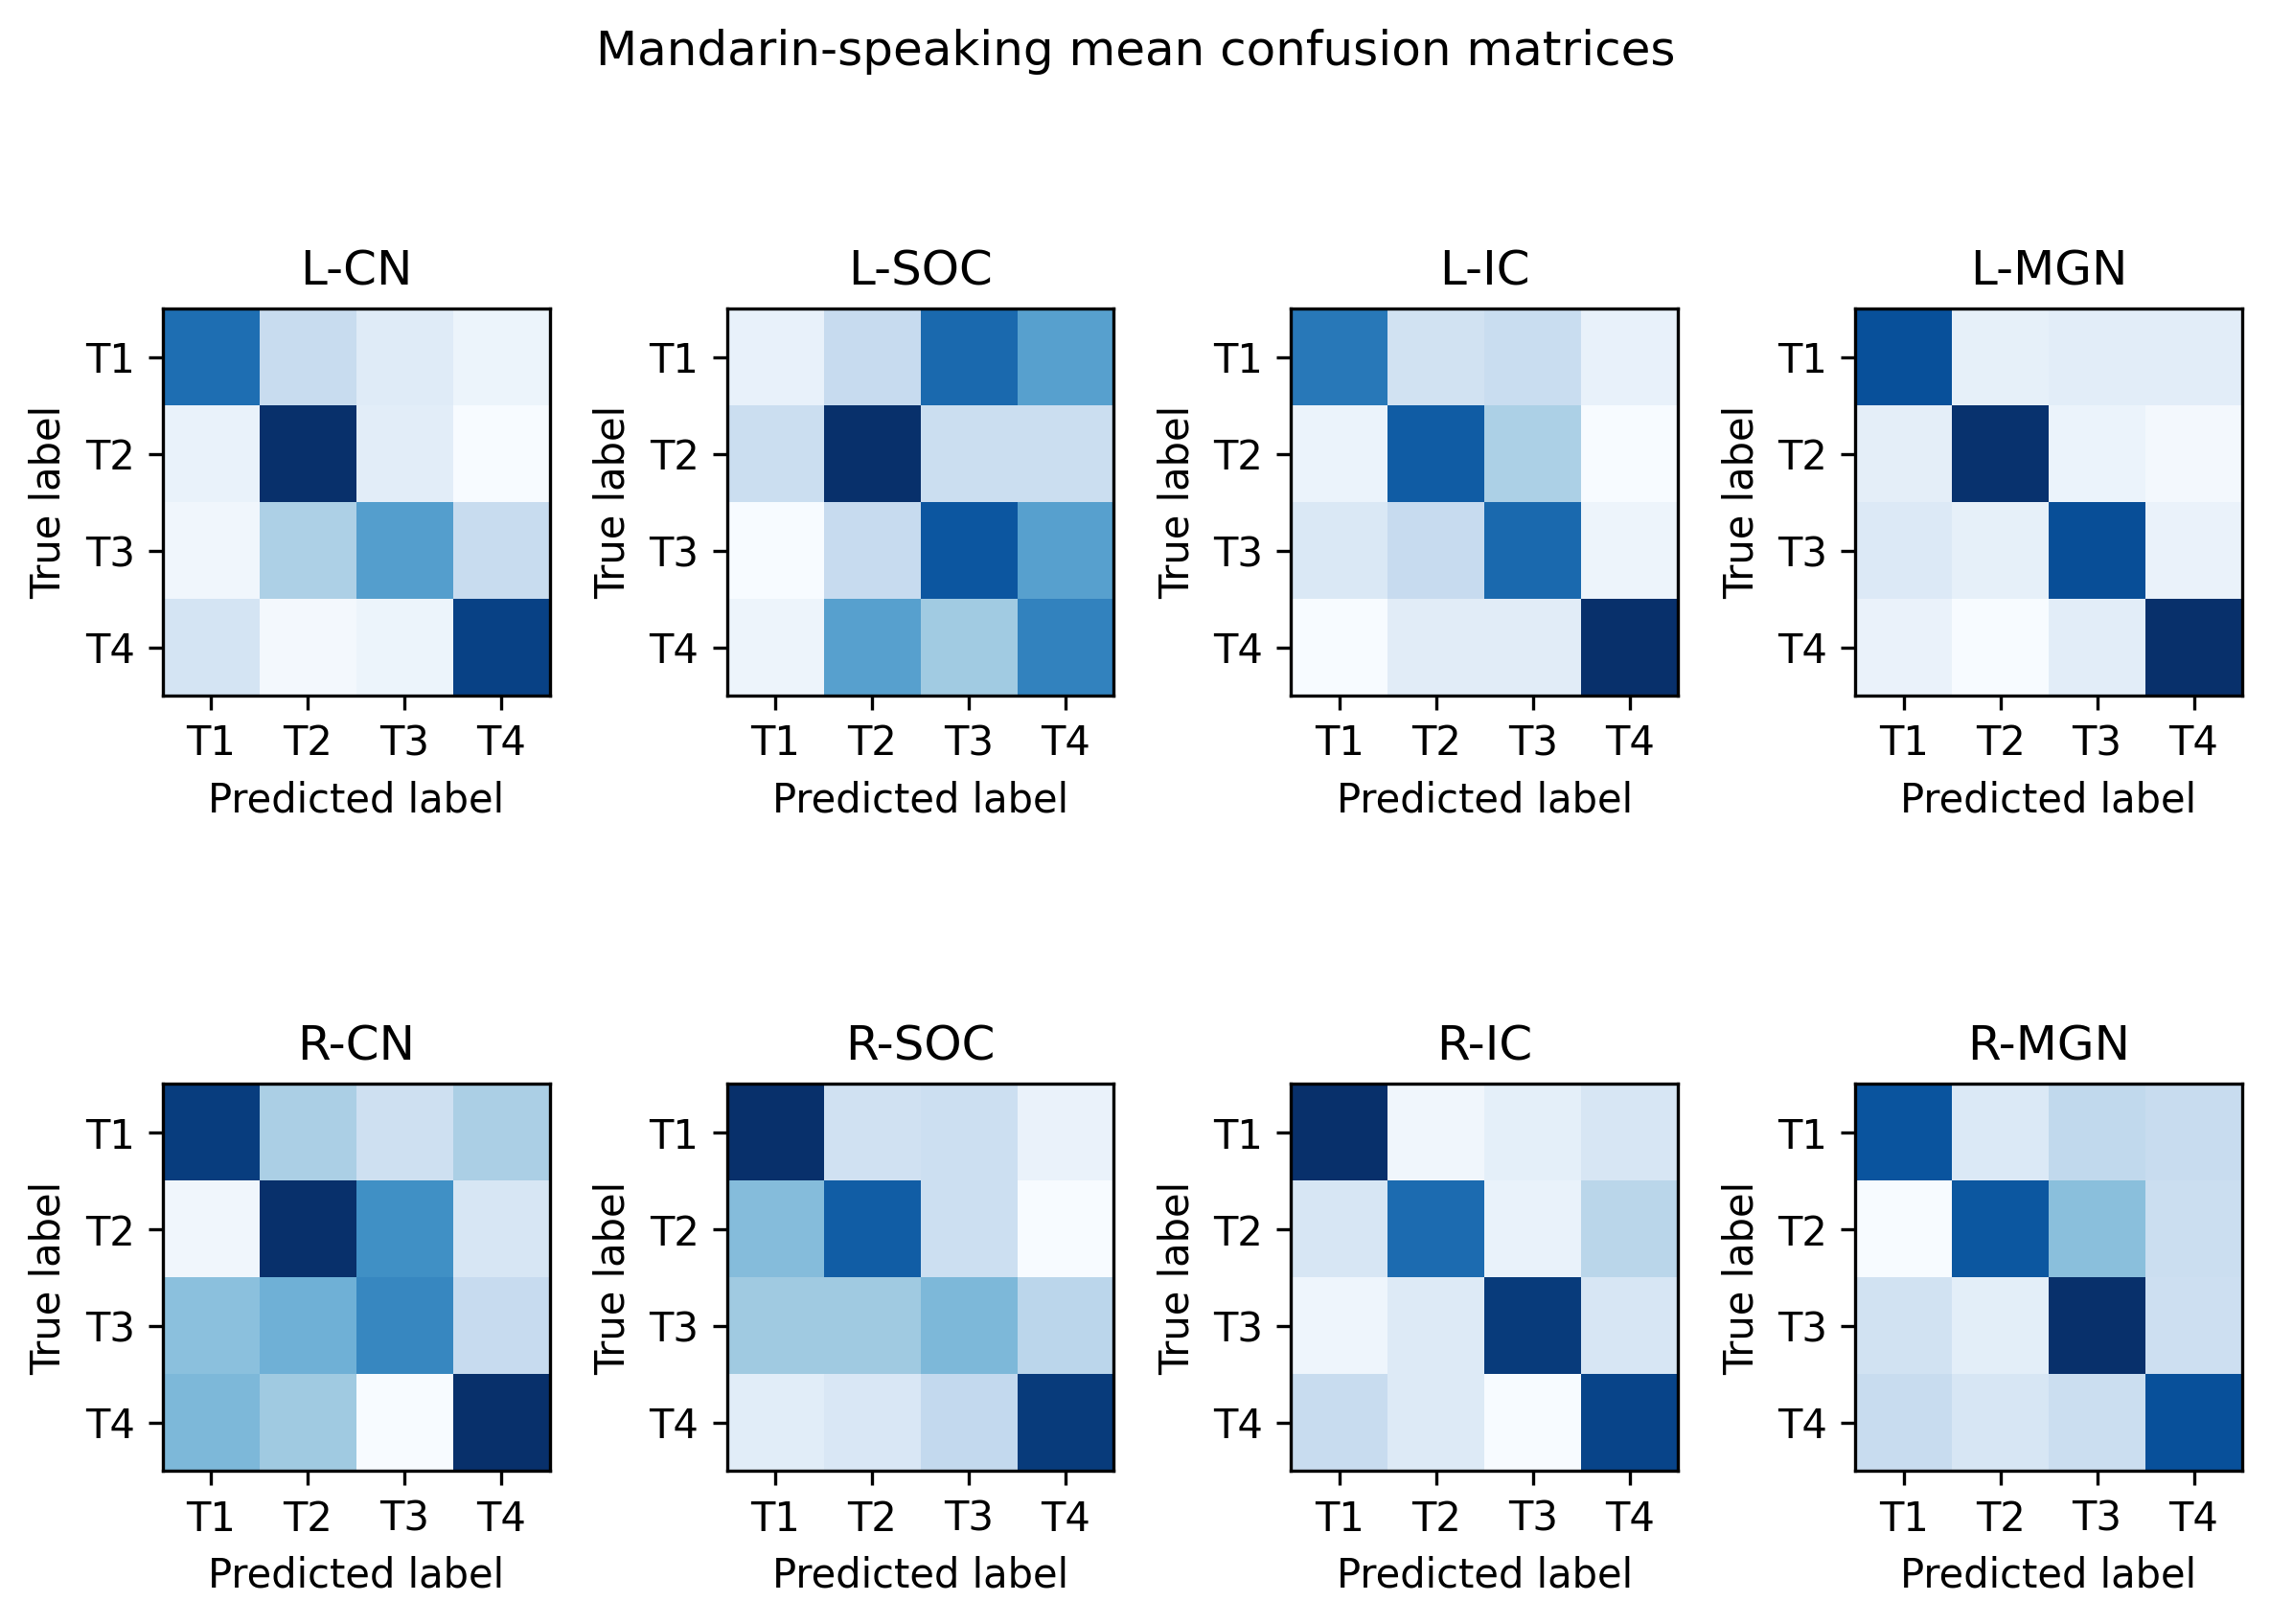

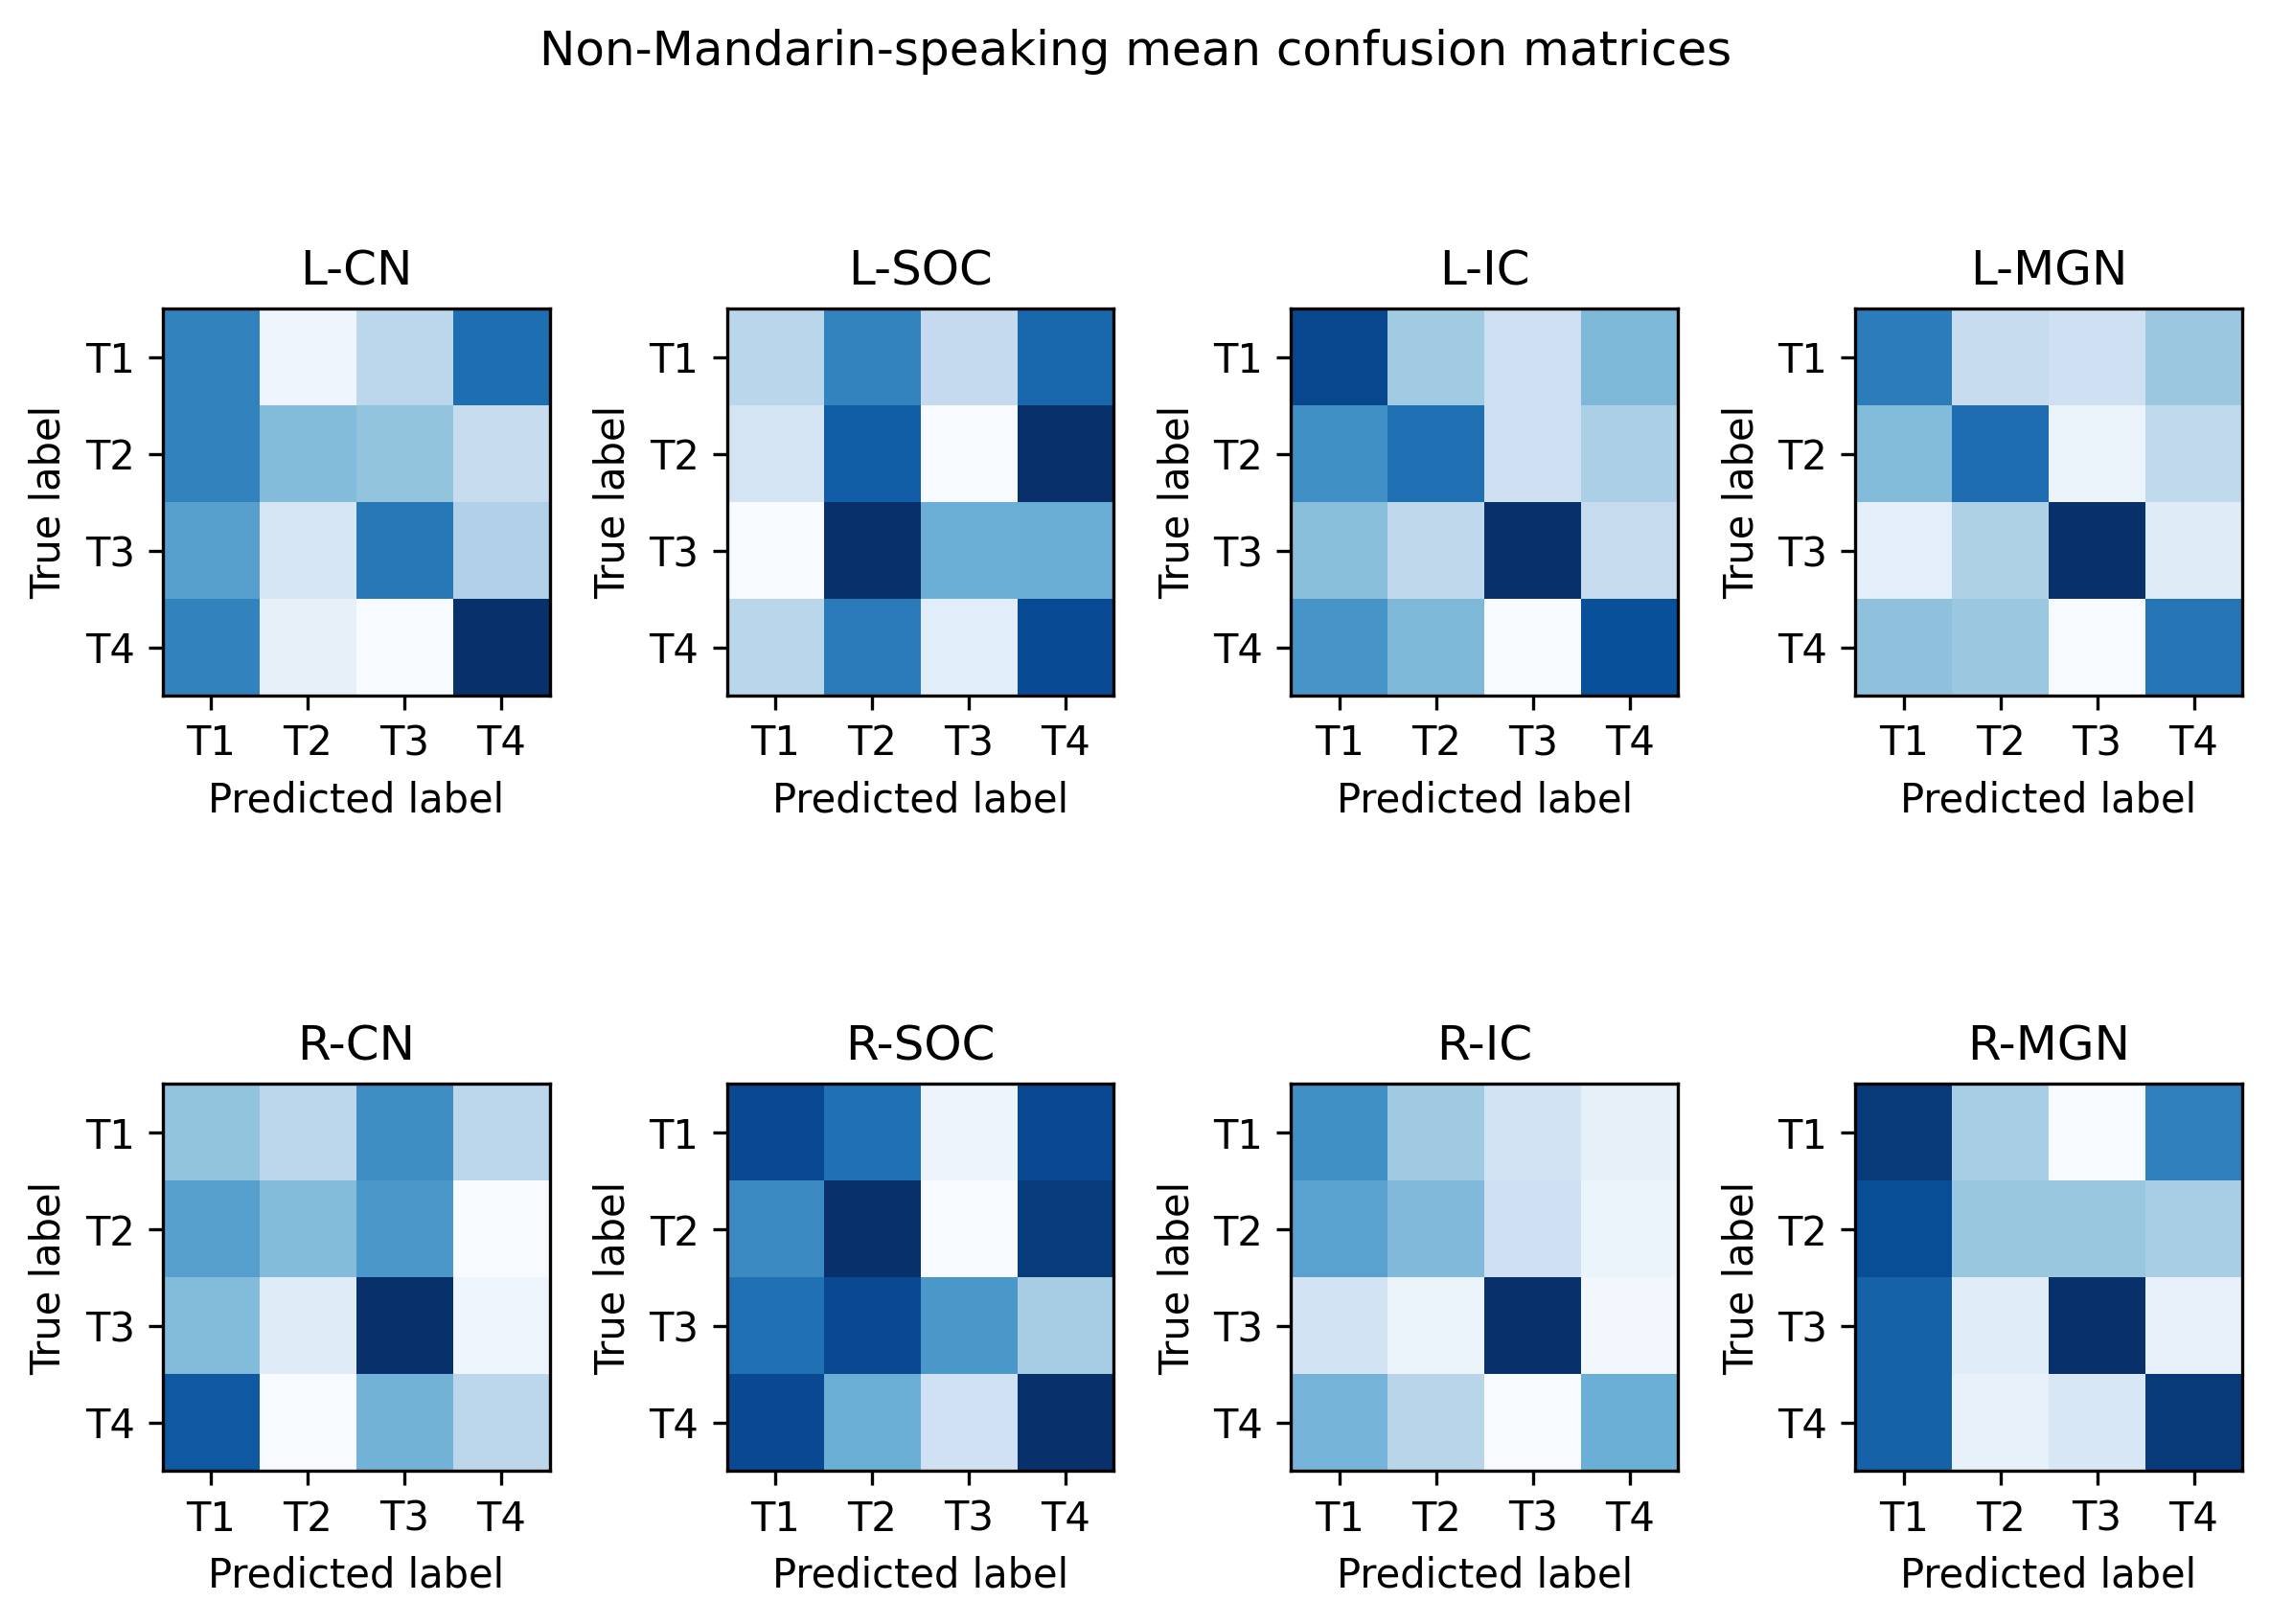

In [17]:
# Mandarin-speaking participants
fig, axs = plt.subplots(nrows=2, ncols=round(num_rois/2), figsize=(num_rois,6), dpi=300)
fig.suptitle('Mandarin-speaking mean confusion matrices')

for mx, mask_descrip in enumerate(roi_list):
    ax = plt.subplot(2, num_rois/2, mx + 1)
    ConfusionMatrixDisplay(mand_mean_cm[mx],).plot(ax=ax, colorbar=False, 
                                                   im_kw={'cmap':'Blues', },
                                                   include_values=False)
    ax.set_title(mask_descrip)
    ax.set_xticklabels(['T1','T2','T3','T4'])
    ax.set_yticklabels(['T1','T2','T3','T4'])
# better spacing
fig.tight_layout()
fig.savefig('group-Mand_aud-subcort_label-shuffled_confusion_matrices.png')

# Non-Mandarin-speaking participants
fig2, axs = plt.subplots(nrows=2, ncols=round(num_rois/2), figsize=(num_rois,6), dpi=300)
fig2.suptitle('Non-Mandarin-speaking mean confusion matrices')

for mx, mask_descrip in enumerate(roi_list):
    ax = plt.subplot(2, num_rois/2, mx + 1)
    ConfusionMatrixDisplay(nman_mean_cm[mx],).plot(ax=ax, colorbar=False, 
                                                   im_kw={'cmap':'Blues', },
                                                   include_values=False)
    ax.set_title(mask_descrip)
    ax.set_xticklabels(['T1','T2','T3','T4'])
    ax.set_yticklabels(['T1','T2','T3','T4'])
# better spacing
fig2.tight_layout()
fig2.savefig('group-NMan_aud-subcort_label-shuffled_confusion_matrices.png')

#### Compare with behavior

In [109]:
from scipy.stats import spearmanr

In [111]:
for sub_id in sub_list:
    print(sub_id)
    behav_cm = np.genfromtxt('behav_confusion_matrices/sub-{}_behav_confusion_matrix.csv'.format(sub_id))    
    behav_off_diag = behav_cm[np.where(~np.eye(behav_cm.shape[0],dtype=bool))]
    #print(behav_off_diag)
    for mx, mask_descrip in enumerate(roi_list):
        mask_cm = np.genfromtxt('striatal_confusion_matrices/sub-{}_mask-{}_label-{}_confusion_matrix.csv'.format(sub_id, mask_descrip, 'tone'))
        mask_off_diag = mask_cm[np.where(~np.eye(mask_cm.shape[0],dtype=bool))]
        #print(mask_off_diag)
        
        r, p = spearmanr(behav_off_diag, mask_off_diag)
        print('{} r = {:.03f} p = {:.03f}'.format(mask_descrip, r, p))

FLT01
L-Caud r = -0.091 p = 0.779
L-Put r = 0.674 p = 0.016
R-Caud r = 0.522 p = 0.082
R-Put r = 1.000 p = 0.000
FLT03
L-Caud r = 0.113 p = 0.727
L-Put r = -0.199 p = 0.535
R-Caud r = 0.739 p = 0.006
R-Put r = 0.739 p = 0.006
FLT05
L-Caud r = 0.180 p = 0.575
L-Put r = 0.158 p = 0.624
R-Caud r = -0.199 p = 0.535
R-Put r = -0.135 p = 0.676
FLT07
L-Caud r = nan p = nan
L-Put r = nan p = nan
R-Caud r = nan p = nan
R-Put r = nan p = nan
FLT08
L-Caud r = nan p = nan
L-Put r = nan p = nan
R-Caud r = nan p = nan
R-Put r = nan p = nan
FLT10
L-Caud r = -0.255 p = 0.424
L-Put r = 0.604 p = 0.037
R-Caud r = -0.174 p = 0.588
R-Put r = -0.134 p = 0.677
FLT02
L-Caud r = 0.024 p = 0.940
L-Put r = 0.297 p = 0.349
R-Caud r = 0.381 p = 0.222
R-Put r = 0.087 p = 0.787
FLT04
L-Caud r = 0.787 p = 0.002
L-Put r = 0.547 p = 0.066
R-Caud r = 0.795 p = 0.002
R-Put r = 0.709 p = 0.010
FLT06
L-Caud r = 0.073 p = 0.822
L-Put r = 0.032 p = 0.923
R-Caud r = 0.198 p = 0.538
R-Put r = 0.273 p = 0.390
FLT09
L-Caud r = 

'1.6.2'

### Run pipeline

In [26]:
from sklearn.model_selection import KFold, StratifiedKFold

fwhm_sub = 0 # 1.5
space_label = 'MNI152NLin2009cAsym' #'T1w' 

cv = StratifiedKFold(n_splits=4)

In [27]:
#roi_list = list(roi_dict.keys())
print(roi_list)

['L-CN', 'L-SOC', 'L-IC', 'L-MGN', 'R-CN', 'R-SOC', 'R-IC', 'R-MGN']


In [38]:
nilearn_sub_dir

'/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT01_space-MNI152NLin2009cAsym/trial_models'

In [ ]:
cv_list_tone = []
cv_list_talker = []
cv_list_null = []
for sub_id in sub_list:
    print(sub_id)
    sub_tone = []
    sub_talker = []
    sub_null = []
    
    for mask_descrip in roi_list:
        # define the mask for the region of interest
        print(mask_descrip)
        masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 'masks-subcort-aud', ) # 'masks-aparc'
        mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
        #mask_img = nib.load(mask_fpath)

        '''
        t1w_fpath = os.path.join(fmriprep_dir, 'sub-%s'%sub_id, 'anat', 
                                 'sub-%s_desc-preproc_T1w.nii.gz'%sub_id)
        print('T1w file path: ', t1w_fpath)
        brainmask_fpath = os.path.join(fmriprep_dir, 'sub-%s'%sub_id, 'anat', 
                                 'sub-%s_desc-brain_mask.nii.gz'%sub_id)
        print('brain mask file path: ', brainmask_fpath)
        '''
        nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                       'level-1_fwhm-%.02f'%fwhm_sub, 
                                       'sub-%s_space-%s'%(sub_id, space_label),
                                       'trial_models')

        stat_maps = sorted(glob(nilearn_sub_dir+'/run*/*di*nii.gz')) # run-specific stimulus beta maps
        #stat_maps = sorted(glob(nilearn_sub_dir+'/trial_models'+'/run*/*di*trial*nii.gz')) # run-specific trial beta maps
        #stat_maps = sorted(glob(nilearn_sub_dir+'/run-all/*di*beta.nii.gz')) # run-all
        print('# of stat maps: ', len(stat_maps))    

        fmri_masked, tone_cv_scores, \
            talker_cv_scores, null_cv_scores = sub_region_svc(sub_id, mask_fpath, stat_maps, cv, 
                                                              fwhm=fwhm_sub, space_label=space_label)
        sub_tone.append(tone_cv_scores)
        sub_talker.append(talker_cv_scores)
        sub_null.append(null_cv_scores)
    
    # append subject cv scores to overall list
    cv_list_tone.append(sub_tone)
    cv_list_talker.append(sub_talker)
    cv_list_null.append(sub_null)

FLT01
L-CN
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.344 with a standard deviation of 0.10
Talker SVC accuracy: 0.266 with a standard deviation of 0.03
Permutation test score: 0.244 with a standard deviation of 0.06
L-SOC
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.281 with a standard deviation of 0.03
Talker SVC accuracy: 0.312 with a standard deviation of 0.04
Permutation test score: 0.245 with a standard deviation of 0.06
L-IC
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.156 with a standard deviation of 0.09
Talker SVC accuracy: 0.250 with a standard deviation of 0.04
Permutation test score: 0.228 with a standard deviation of 0.06
L-MGN
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.172 with a standard deviation of 0.05
Talker SVC accuracy: 0.266 with a standard deviation of 0.07
Permutation test score: 0.229 with a standard deviation of 0.06
R-CN
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.219 with a standard deviation of 0.11
Talker SVC accuracy: 0.203 with a standard deviation of 0.08
Permutation test score: 0.248 with a standard deviation of 0.06
R-SOC
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.359 with a standard deviation of 0.16
Talker SVC accuracy: 0.234 with a standard deviation of 0.09
Permutation test score: 0.240 with a standard deviation of 0.07
R-IC
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.328 with a standard deviation of 0.15
Talker SVC accuracy: 0.188 with a standard deviation of 0.08
Permutation test score: 0.237 with a standard deviation of 0.06
R-MGN
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.344 with a standard deviation of 0.13
Talker SVC accuracy: 0.266 with a standard deviation of 0.05
Permutation test score: 0.234 with a standard deviation of 0.05
FLT03
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.08
Talker SVC accuracy: 0.240 with a standard deviation of 0.02
Permutation test score: 0.244 with a standard deviation of 0.04
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.281 with a standard deviation of 0.07
Talker SVC accuracy: 0.281 with a standard deviation of 0.03
Permutation test score: 0.246 with a standard deviation of 0.06
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.05
Talker SVC accuracy: 0.187 with a standard deviation of 0.06
Permutation test score: 0.220 with a standard deviation of 0.05
L-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.344 with a standard deviation of 0.15
Talker SVC accuracy: 0.323 with a standard deviation of 0.09
Permutation test score: 0.212 with a standard deviation of 0.05
R-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.458 with a standard deviation of 0.10
Talker SVC accuracy: 0.219 with a standard deviation of 0.07
Permutation test score: 0.232 with a standard deviation of 0.05
R-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.198 with a standard deviation of 0.07
Talker SVC accuracy: 0.229 with a standard deviation of 0.04
Permutation test score: 0.233 with a standard deviation of 0.05
R-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.292 with a standard deviation of 0.18
Talker SVC accuracy: 0.260 with a standard deviation of 0.05
Permutation test score: 0.216 with a standard deviation of 0.05
R-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.302 with a standard deviation of 0.10
Talker SVC accuracy: 0.219 with a standard deviation of 0.07
Permutation test score: 0.230 with a standard deviation of 0.06
FLT05
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.240 with a standard deviation of 0.07
Talker SVC accuracy: 0.250 with a standard deviation of 0.05
Permutation test score: 0.241 with a standard deviation of 0.05
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.250 with a standard deviation of 0.03
Talker SVC accuracy: 0.188 with a standard deviation of 0.05
Permutation test score: 0.239 with a standard deviation of 0.05
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.406 with a standard deviation of 0.09
Talker SVC accuracy: 0.302 with a standard deviation of 0.05
Permutation test score: 0.242 with a standard deviation of 0.05
L-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.417 with a standard deviation of 0.10
Talker SVC accuracy: 0.229 with a standard deviation of 0.07
Permutation test score: 0.217 with a standard deviation of 0.05
R-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.365 with a standard deviation of 0.08
Talker SVC accuracy: 0.281 with a standard deviation of 0.09
Permutation test score: 0.228 with a standard deviation of 0.06
R-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.281 with a standard deviation of 0.11
Talker SVC accuracy: 0.177 with a standard deviation of 0.05
Permutation test score: 0.238 with a standard deviation of 0.05
R-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.02
Talker SVC accuracy: 0.250 with a standard deviation of 0.00
Permutation test score: 0.227 with a standard deviation of 0.05
R-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.240 with a standard deviation of 0.03
Talker SVC accuracy: 0.250 with a standard deviation of 0.08
Permutation test score: 0.235 with a standard deviation of 0.05
FLT07
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.312 with a standard deviation of 0.07
Talker SVC accuracy: 0.229 with a standard deviation of 0.06
Permutation test score: 0.239 with a standard deviation of 0.04
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.323 with a standard deviation of 0.05
Talker SVC accuracy: 0.271 with a standard deviation of 0.05
Permutation test score: 0.245 with a standard deviation of 0.05
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.11
Talker SVC accuracy: 0.271 with a standard deviation of 0.05
Permutation test score: 0.228 with a standard deviation of 0.06
L-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.333 with a standard deviation of 0.15
Talker SVC accuracy: 0.250 with a standard deviation of 0.05
Permutation test score: 0.216 with a standard deviation of 0.05
R-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.313 with a standard deviation of 0.06
Talker SVC accuracy: 0.333 with a standard deviation of 0.06
Permutation test score: 0.233 with a standard deviation of 0.05
R-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.385 with a standard deviation of 0.14
Talker SVC accuracy: 0.208 with a standard deviation of 0.05
Permutation test score: 0.231 with a standard deviation of 0.05
R-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.10
Talker SVC accuracy: 0.354 with a standard deviation of 0.07
Permutation test score: 0.223 with a standard deviation of 0.06
R-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.427 with a standard deviation of 0.11
Talker SVC accuracy: 0.312 with a standard deviation of 0.02
Permutation test score: 0.218 with a standard deviation of 0.05
FLT08
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.385 with a standard deviation of 0.12
Talker SVC accuracy: 0.281 with a standard deviation of 0.03
Permutation test score: 0.238 with a standard deviation of 0.06
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.312 with a standard deviation of 0.06
Talker SVC accuracy: 0.260 with a standard deviation of 0.05
Permutation test score: 0.257 with a standard deviation of 0.05
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.375 with a standard deviation of 0.07
Talker SVC accuracy: 0.229 with a standard deviation of 0.06
Permutation test score: 0.229 with a standard deviation of 0.04
L-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.438 with a standard deviation of 0.06
Talker SVC accuracy: 0.292 with a standard deviation of 0.04
Permutation test score: 0.241 with a standard deviation of 0.05
R-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.219 with a standard deviation of 0.12
Talker SVC accuracy: 0.260 with a standard deviation of 0.05
Permutation test score: 0.241 with a standard deviation of 0.05
R-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.146 with a standard deviation of 0.05
Talker SVC accuracy: 0.302 with a standard deviation of 0.05
Permutation test score: 0.242 with a standard deviation of 0.05
R-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.05
Talker SVC accuracy: 0.260 with a standard deviation of 0.03
Permutation test score: 0.226 with a standard deviation of 0.04
R-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.323 with a standard deviation of 0.14
Talker SVC accuracy: 0.219 with a standard deviation of 0.06
Permutation test score: 0.226 with a standard deviation of 0.05
FLT10
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.281 with a standard deviation of 0.16
Talker SVC accuracy: 0.260 with a standard deviation of 0.05
Permutation test score: 0.227 with a standard deviation of 0.05
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.208 with a standard deviation of 0.05
Talker SVC accuracy: 0.250 with a standard deviation of 0.05
Permutation test score: 0.243 with a standard deviation of 0.05
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.260 with a standard deviation of 0.05
Talker SVC accuracy: 0.188 with a standard deviation of 0.02
Permutation test score: 0.235 with a standard deviation of 0.04
L-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.396 with a standard deviation of 0.06
Talker SVC accuracy: 0.260 with a standard deviation of 0.09
Permutation test score: 0.219 with a standard deviation of 0.04
R-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.198 with a standard deviation of 0.06
Talker SVC accuracy: 0.219 with a standard deviation of 0.03
Permutation test score: 0.240 with a standard deviation of 0.05
R-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.281 with a standard deviation of 0.07
Talker SVC accuracy: 0.302 with a standard deviation of 0.05
Permutation test score: 0.242 with a standard deviation of 0.05
R-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.385 with a standard deviation of 0.10
Talker SVC accuracy: 0.260 with a standard deviation of 0.03
Permutation test score: 0.224 with a standard deviation of 0.05
R-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.271 with a standard deviation of 0.14
Talker SVC accuracy: 0.302 with a standard deviation of 0.05
Permutation test score: 0.249 with a standard deviation of 0.04
FLT02
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.281 with a standard deviation of 0.02
Talker SVC accuracy: 0.198 with a standard deviation of 0.03
Permutation test score: 0.243 with a standard deviation of 0.05
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.06
Talker SVC accuracy: 0.260 with a standard deviation of 0.06
Permutation test score: 0.235 with a standard deviation of 0.05
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.396 with a standard deviation of 0.10
Talker SVC accuracy: 0.198 with a standard deviation of 0.05
Permutation test score: 0.233 with a standard deviation of 0.05
L-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.323 with a standard deviation of 0.08
Talker SVC accuracy: 0.219 with a standard deviation of 0.02
Permutation test score: 0.228 with a standard deviation of 0.05
R-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.219 with a standard deviation of 0.02
Talker SVC accuracy: 0.219 with a standard deviation of 0.02
Permutation test score: 0.249 with a standard deviation of 0.05
R-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.406 with a standard deviation of 0.09
Talker SVC accuracy: 0.260 with a standard deviation of 0.05
Permutation test score: 0.247 with a standard deviation of 0.05
R-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.323 with a standard deviation of 0.09
Talker SVC accuracy: 0.219 with a standard deviation of 0.07
Permutation test score: 0.234 with a standard deviation of 0.05
R-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.219 with a standard deviation of 0.09
Talker SVC accuracy: 0.229 with a standard deviation of 0.07
Permutation test score: 0.221 with a standard deviation of 0.05
FLT04
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.250 with a standard deviation of 0.07
Talker SVC accuracy: 0.302 with a standard deviation of 0.08
Permutation test score: 0.244 with a standard deviation of 0.06
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.365 with a standard deviation of 0.05
Talker SVC accuracy: 0.333 with a standard deviation of 0.09
Permutation test score: 0.243 with a standard deviation of 0.05
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.271 with a standard deviation of 0.06
Talker SVC accuracy: 0.240 with a standard deviation of 0.05
Permutation test score: 0.233 with a standard deviation of 0.06
L-MGN
# of stat maps:  96


In [26]:
'''
np.save('cv_list_tone', cv_list_tone)
np.save('cv_list_talker', cv_list_talker)
np.save('cv_list_null', cv_list_null)
np.save('sub_list', sub_list)
np.save('roi_list', roi_list)
'''

In [28]:
import pandas as pd

In [30]:
pd.DataFrame(data=cv_list_tone)

0   \
0                         [0.25, 0.1875, 0.25, 0.375]   
1             [0.4583333333333333, 0.375, 0.5, 0.625]   
2   [0.4166666666666667, 0.5833333333333334, 0.541...   
3   [0.375, 0.375, 0.7083333333333334, 0.333333333...   
4   [0.3333333333333333, 0.3333333333333333, 0.5, ...   
5   [0.5416666666666666, 0.5, 0.4583333333333333, ...   
6   [0.20833333333333334, 0.25, 0.5416666666666666...   
7   [0.20833333333333334, 0.375, 0.208333333333333...   
8   [0.20833333333333334, 0.20833333333333334, 0.4...   
9             [0.375, 0.5, 0.4166666666666667, 0.375]   
10  [0.2916666666666667, 0.375, 0.4166666666666667...   
11  [0.375, 0.25, 0.5416666666666666, 0.3333333333...   
12  [0.4166666666666667, 0.3333333333333333, 0.5, ...   

                                                   1   \
0                        [0.125, 0.1875, 0.25, 0.375]   
1   [0.5, 0.5416666666666666, 0.5, 0.5833333333333...   
2   [0.375, 0.3333333333333333, 0.5416666666666666...   
3   [0.4583333333333333, 0.4583333333333333, 0.583...   
4           [0.375, 0.375, 0.375, 0.4166666666666667]   
5   [0.5, 0.5416666666666666, 0.5833333333333334, ...   
6   [0.20833333333333334, 0.2916666666666667, 0.45...   
7   [0.16666666666666666, 0.4166666666666667, 0.29...   
8             [0.25, 0.25, 0.375, 0.3333333333333333]   
9   [0.3333333333333333, 0.25, 0.5416666666666666,...   
10  [0.3333333333333333, 0.4166666666666667, 0.458...   
11  [0.375, 0.4583333333333333, 0.5416666666666666...   
12  [0.3333333333333333, 0.125, 0.5, 0.41666666666...   

                                                   2   \
0                           [0.25, 0.25, 0.25, 0.375]   
1   [0.625, 0.4583333333333333, 0.5416666666666666...   
2   [0.4583333333333333, 0.5833333333333334, 0.5, ...   
3   [0.20833333333333334, 0.4583333333333333, 0.5,...   
4   [0.3333333333333333, 0.20833333333333334, 0.33...   
5   [0.375, 0.5833333333333334, 0.5, 0.54166666666...   
6   [0.16666666666666666, 0.25, 0.5416666666666666...   
7   [0.2916666666666667, 0.2916666666666667, 0.5, ...   
8   [0.25, 0.2916666666666667, 0.2916666666666667,...   
9   [0.2916666666666667, 0.3333333333333333, 0.333...   
10  [0.20833333333333334, 0.2916666666666667, 0.37...   
11  [0.375, 0.375, 0.2916666666666667, 0.291666666...   
12  [0.5, 0.4166666666666667, 0.5833333333333334, ...   

                                                   3   \
0                          [0.3125, 0.5, 0.25, 0.375]   
1   [0.5, 0.4166666666666667, 0.4583333333333333, ...   
2   [0.5, 0.6666666666666666, 0.5416666666666666, ...   
3   [0.5416666666666666, 0.625, 0.4166666666666667...   
4   [0.375, 0.16666666666666666, 0.333333333333333...   
5   [0.375, 0.6666666666666666, 0.4583333333333333...   
6                          [0.25, 0.25, 0.625, 0.375]   
7   [0.375, 0.25, 0.4583333333333333, 0.2916666666...   
8   [0.20833333333333334, 0.2916666666666667, 0.33...   
9   [0.4166666666666667, 0.3333333333333333, 0.541...   
10  [0.08333333333333333, 0.25, 0.4583333333333333...   
11  [0.3333333333333333, 0.3333333333333333, 0.208...   
12           [0.375, 0.25, 0.5416666666666666, 0.375]   

                                                   4   \
0                       [0.3125, 0.375, 0.25, 0.3125]   
1   [0.5833333333333334, 0.4583333333333333, 0.541...   
2   [0.5, 0.5416666666666666, 0.5416666666666666, ...   
3   [0.4166666666666667, 0.4583333333333333, 0.5, ...   
4   [0.4166666666666667, 0.25, 0.4583333333333333,...   
5   [0.5, 0.4166666666666667, 0.375, 0.45833333333...   
6   [0.2916666666666667, 0.20833333333333334, 0.58...   
7   [0.2916666666666667, 0.16666666666666666, 0.33...   
8   [0.25, 0.16666666666666666, 0.2916666666666667...   
9   [0.4583333333333333, 0.3333333333333333, 0.416...   
10  [0.16666666666666666, 0.20833333333333334, 0.4...   
11  [0.3333333333333333, 0.3333333333333333, 0.625...   
12  [0.4166666666666667, 0.375, 0.3333333333333333...   

                                                   5   \

## Searchlight

In [14]:
def fit_searchlight(region_mask, brain_mask, fmri_img, y):
    # Define the cross-validation scheme used for validation.
    # Here we use a KFold cross-validation on the session, which corresponds to
    # splitting the samples in 4 folds and make 4 runs using each fold as a test
    # set once and the others as learning sets
    from sklearn.model_selection import KFold, StratifiedKFold
    cv = StratifiedKFold(n_splits=4)

    import nilearn.decoding
    # The radius is the one of the Searchlight sphere that will scan the volume
    searchlight = nilearn.decoding.SearchLight(
        brain_mask,
        process_mask_img=region_mask,
        radius=4.5,
        verbose=1, cv=cv, n_jobs=1)
    searchlight.fit(fmri_img, y)
    
    return searchlight

In [15]:
from nilearn.image import new_img_like

fwhm_sub = 0 #1.5
space_label = 'MNI152NLin2009cAsym'

roi_list = list(roi_dict.keys())
print(roi_list)
num_rois = len(roi_list)

['L-CN', 'L-SOC', 'L-IC', 'L-MGN', 'R-CN', 'R-SOC', 'R-IC', 'R-MGN']


In [ ]:
for sub_id in sub_list:
    
    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                   'level-1_fwhm-%.02f'%fwhm_sub, 
                                   'sub-%s_space-%s'%(sub_id, space_label))
    print(nilearn_sub_dir)
    
    # run-specific stimulus beta maps
    stat_maps = sorted(glob(nilearn_sub_dir+'/stimulus_per_run'+'/run*/*di*nii.gz')) 
    print('# of stat maps: ', len(stat_maps))   
    
    f_affine = nib.load(stat_maps[0]).affine
    
    # read in the overall brain mask
    anat_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/',
                            'derivatives/fmriprep_noSDC/sub-{}/anat'.format(sub_id))
    brainmask_fpath = os.path.join(anat_dir, 'sub-{}_space-{}_desc-brain_mask.nii.gz'.format(sub_id, space_label))
    
    # generate condition labels based on filenames
    conditions_tone, conditions_talker, conditions_all, conditions_shuffled = create_labels(stat_maps)
    
    # create output directory
    sub_out_dir = os.path.join(nilearn_sub_dir, 'searchlight')
    if not os.path.exists(sub_out_dir):
        os.makedirs(sub_out_dir)
    
    for mx, mask_descrip in enumerate(roi_list):
        # define the mask for the region of interest
        print(mask_descrip)
        masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 'masks-dseg', )
        mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
        
        #fmri_masked, masker = mask_fmri(stat_maps, mask_fpath, fwhm_sub)
        
        searchlight = fit_searchlight(mask_fpath, brainmask_fpath, stat_maps, conditions_tone)
        
        searchlight_img = new_img_like(stat_maps[0], searchlight.scores_, affine=f_affine)
        
        out_fpath = os.path.join(sub_out_dir, 'sub-{}_space-{}_mask-{}_searchlight.nii.gz'.format(sub_id, space_label, mask_descrip))
        nib.save(searchlight_img, out_fpath)
        print('saved searchlight image to ', out_fpath)


### group overlap

In [23]:
thr_acc = 0.33

fwhm = 1.5
space_label = 'MNI152NLin2009cAsym'

roi_list = list(roi_dict.keys())

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                   'level-1_fwhm-%.02f'%fwhm)

for group_label in ['mand', 'nman']:
    if group_label == 'mand':
        sub_loop_list = sub_list_mand
    elif group_label == 'nman':
        sub_loop_list = sub_list_nman

    for mask_label in ['gm-thr90_cond-tone']: #roi_list:
        #mask_label = 'L-Put'
        print(mask_label)
        mask_sl_thr_array = []

        for sx, sub_id in enumerate(sub_loop_list):
            #sub_id = 'FLT08'
            sub_mask_sl_fpath = os.path.join(nilearn_dir, 'sub-%s_space-%s'%(sub_id, space_label), 'searchlight', 
                                             'sub-{}_space-{}_mask-{}_searchlight.nii.gz'.format(sub_id, space_label, mask_label))
            sub_sl_img = nib.load(sub_mask_sl_fpath)

            sub_sl_data = sub_sl_img.get_fdata()

            # threshold/binarize
            sub_sl_thr = np.where(sub_sl_data > thr_acc, 1, 0)
            mask_sl_thr_array.append(sub_sl_thr)

        # create a group count image
        group_mask_sl_thr = np.sum(mask_sl_thr_array, axis=0)
        group_sl_img = nib.Nifti1Image(group_mask_sl_thr, affine=sub_sl_img.affine)
        group_sl_dir = os.path.join(nilearn_dir, 'searchlight_group')
        if not os.path.exists(group_sl_dir):
                os.makedirs(group_sl_dir)
        group_sl_fpath = os.path.join(group_sl_dir, 'group-{}_mask-{}_searchlight_thr-{}.nii.gz'.format(group_label, mask_label, thr_acc))
        nib.save(group_sl_img, group_sl_fpath)

gm-thr90_cond-tone
gm-thr90_cond-tone


In [42]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_img
t1w_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT10/anat',
                         'sub-FLT10_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz')

In [ ]:
thr_acc = 0.33
group_label='mand'
num_rois = len(roi_list)

fig, axs = plt.subplots(nrows=round(num_rois/2), ncols=2, figsize=(12, num_rois), dpi=300)
fig.suptitle('Mandarin-speaking searchlight accuracy > {}'.format(thr_acc))

for mx, ax in enumerate(axs.T.flatten()):
    mask_label = roi_list[mx]
    print(mask_label)
    group_img = os.path.join(group_sl_dir, 'group-{}_mask-{}_searchlight_thr-{}.nii.gz'.format(group_label, mask_label, thr_acc))
    #ax = plt.subplot(num_rois/2, 2, mx + 1)
    display = plot_img(group_img, bg_img=t1w_fpath, 
                         title=mask_label,
                         #cmap='hot', 
                         threshold=5.5, 
                         vmin=0, vmax=6,
                         black_bg=True,
                         colorbar=True,
                         cbar_tick_format="%i",
                         axes=ax)
#fig.savefig('group-{}_searchlight_thr-{}.png'.format(group_label, thr_acc))

In [ ]:
thr_acc = 0.33
group_label='nman'
num_rois = len(roi_list)

fig, axs = plt.subplots(nrows=round(num_rois/2), ncols=2, figsize=(12, num_rois), dpi=300)
fig.suptitle('Non-Mandarin-speaking searchlight accuracy > {}'.format(thr_acc))

for mx, ax in enumerate(axs.T.flatten()):
    mask_label = roi_list[mx]
    print(mask_label)
    group_img = os.path.join(group_sl_dir, 'group-{}_mask-{}_searchlight_thr-{}.nii.gz'.format(group_label, mask_label, thr_acc))
    #ax = plt.subplot(num_rois/2, 2, mx + 1)
    display = plot_img(group_img, bg_img=t1w_fpath, 
                         title=mask_label,
                         cmap='hot', 
                         threshold=4.5, 
                         vmin=0, vmax=6,
                         black_bg=True,
                         colorbar=True,
                         cbar_tick_format="%i",
                         axes=ax)
fig.savefig('group-{}_searchlight_thr-{}.png'.format(group_label, thr_acc))

### plot gray matter searchlight

#### first, make gray matter masks

In [56]:
def generate_mask(subject_id, statmap_example_fpath, out_dir, space_label):
    from nilearn.image import resample_to_img
    
    # read in the overall brain mask
    anat_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/',
                            'derivatives/fmriprep_noSDC/sub-{}/anat'.format(subject_id))

    # create binarized gray matter mask
    gm_fpath = os.path.join(anat_dir, 'sub-{}_space-{}_label-GM_probseg.nii.gz'.format(subject_id, space_label))
    gm_img = nib.load(gm_fpath)
    
    from nilearn.image import binarize_img
    gm_bin_img = binarize_img(gm_img, threshold=0.9)
    
    '''
    atlas_img = nib.load(atlas_fpath)
    atlas_data = atlas_img.get_fdata()
    atlas_affine = atlas_img.affine
    
    mask_data = np.zeros((atlas_data.shape))
    mask_data[np.where(atlas_data == labelnum)] = 1

    mask_img = nib.Nifti1Image(mask_data, atlas_affine)
    '''

    mask_func_img = resample_to_img(gm_bin_img, statmap_example_fpath, interpolation='nearest')
    
    labelname = 'gm-thr90'
    out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(subject_id, space_label, labelname))
    nib.save(mask_func_img, out_fpath)
    
    return out_fpath

In [ ]:
'''
space_label == 'MNI152NLin2009cAsym'
for mx, sub_id in enumerate(sub_list):
    print(sub_id)
    
    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                               'level-1_fwhm-%.02f'%fwhm_sub, 
                                               'sub-%s_space-%s'%(sub_id, space_label))    
    statmap_example_fpath = z_maps = sorted(glob(nilearn_sub_dir+'/trial_models/run*/*di*beta.nii.gz'))[0]

    
    atlas_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/',
                               'reference/', #tpl-MNI152NLin2009cAsym/',
                               'tpl-MNI152NLin2009cAsym_res-01_desc-carpet_dseg.nii.gz')  
    sub_mask_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 
                                'space-%s'%space_label, 'masks-dseg')   

    if not os.path.exists(sub_mask_dir):
        os.makedirs(sub_mask_dir)
    
    mask_fpath = generate_mask(sub_id, statmap_example_fpath, sub_mask_dir, space_label)
'''

In [16]:
from nilearn import plotting
from nilearn.image import new_img_like
from nilearn.image import math_img, threshold_img
import matplotlib.pyplot as plt

In [30]:
space_label = 'MNI152NLin2009cAsym'
deriv_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/',
                         'data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50')
print(sub_list)

['FLT01', 'FLT03', 'FLT05', 'FLT07', 'FLT08', 'FLT10', 'FLT02', 'FLT04', 'FLT06', 'FLT09', 'FLT11', 'FLT12', 'FLT13']


In [ ]:
group_label = 'mand'
thr_acc = 0.33
thr_sub = 5.5
thr_cl = 10
fpath_list = []
for mask_label in ['L-Caud', 'L-Put', 'R-Caud', 'R-Put']:
    group_fpath = os.path.join(deriv_dir, 'searchlight_group', 
                         'group-{}_mask-{}_searchlight_thr-{}.nii.gz'.format(group_label, mask_label, thr_acc))
    fpath_list.append(group_fpath)

joint_img = math_img('img1+img2+img3+img4', img1=fpath_list[0], img2=fpath_list[1], img3=fpath_list[2], img4=fpath_list[3])
joint_thr_img = threshold_img(joint_img, thr_sub, cluster_threshold=thr_cl)

display = plotting.plot_img(joint_thr_img, bg_img=t1w_fpath, 
                             title='group-{} 100% overlap (cluster threshold > {} voxels)'.format(group_label, thr_cl),
                             cmap='winter', 
                             threshold=thr_sub, 
                             vmin=0, vmax=6,
                             black_bg=False,
                             #colorbar=True,
                             #cbar_tick_format="%i",
                            display_mode='y',
                            #cut_coords=[-15, -10, -5, 0, 5, 10, 15, 20],
                             #axes=ax
                          )

display = plotting.plot_img(joint_thr_img, bg_img=t1w_fpath, 
                             #title='group-{} 100% overlap (cluster threshold > {} voxels)'.format(group_label, thr_cl),
                             cmap='winter', 
                             threshold=thr_sub, 
                             vmin=0, vmax=6,
                             black_bg=False,
                             #colorbar=True,
                             #cbar_tick_format="%i",
                            display_mode='x',
                            #cut_coords=[-15, -10, -5, 0, 5, 10, 15, 20],
                             #axes=ax
                          )



#### Single subject striatum plots

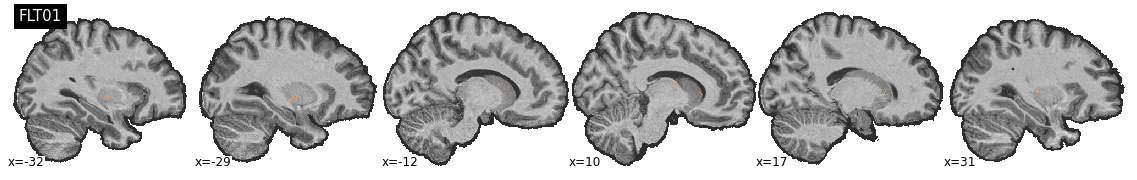

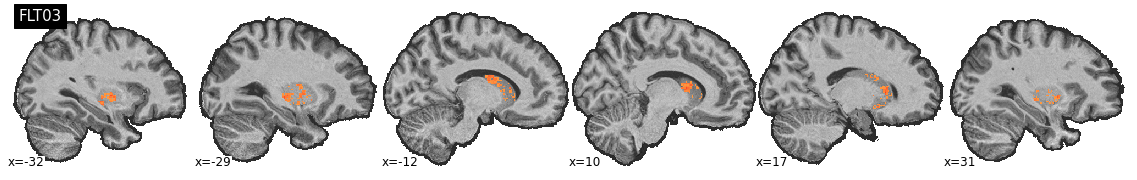

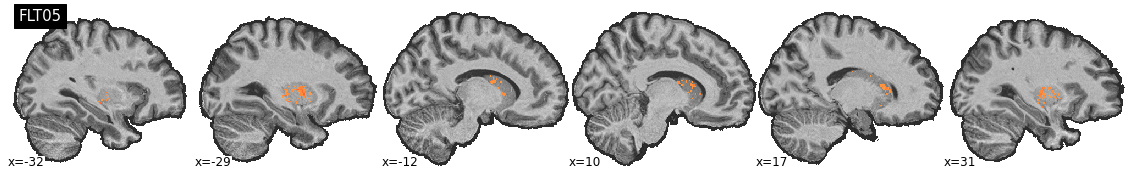

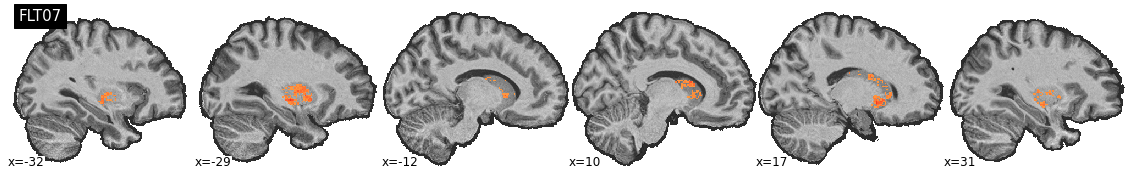

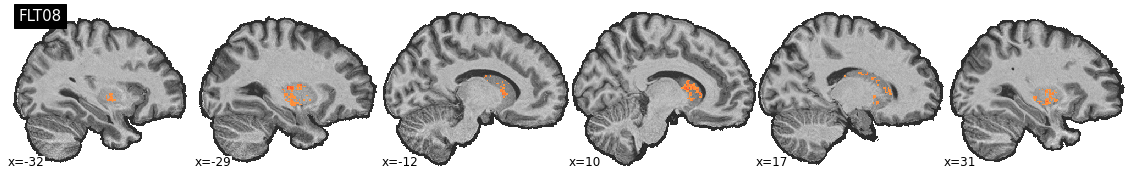

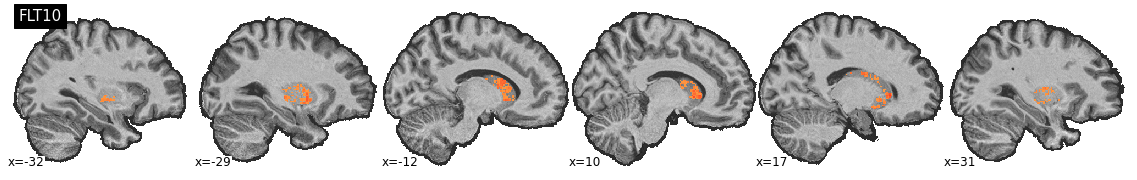

In [42]:
thr_acc = 0.45
thr_cl = 10
fpath_list = []
t1w_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT08/anat',
                         'sub-FLT08_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz')
for sub_id in sub_list_mand:
    
    fpath_list = []
    for mask_label in ['L-Caud', 'L-Put', 'R-Caud', 'R-Put']:
        sub_mask_sl_fpath = os.path.join(deriv_dir, 'sub-%s_space-%s'%(sub_id, space_label), 'searchlight', 
                                             'sub-{}_space-{}_mask-{}_searchlight.nii.gz'.format(sub_id, space_label, mask_label))
        fpath_list.append(sub_mask_sl_fpath)

    joint_img = math_img('img1+img2+img3+img4', img1=fpath_list[0], img2=fpath_list[1], img3=fpath_list[2], img4=fpath_list[3])
    
    #joint_thr_img = threshold_img(joint_img, thr_acc, cluster_threshold=thr_cl)
    
    
    display = plotting.plot_img(joint_img, bg_img=t1w_fpath, 
                                title=sub_id,
                                cmap='YlOrRd', 
                                threshold=thr_acc, 
                                vmin=0, vmax=1,
                                black_bg=False,
                                #colorbar=True,
                                #cbar_tick_format="%i",
                                display_mode='x',
                                cut_coords=[-32, -29, -12, 10, 17, 31],
                                #axes=ax
                                )
    display.savefig('striatal_searchlight/sub-{}_thr-{}.png'.format(sub_id, thr_acc))

L-Put


'\ngroup_label=\'nman\'\n#num_rois = len(roi_list)\n\n#fig, axs = plt.subplots(nrows=round(num_rois/2), ncols=2, figsize=(12, num_rois), dpi=300)\n#fig.suptitle(\'Mandarin-speaking searchlight accuracy > {}\'.format(thr_acc))\n\nsub_id = \'FLT08\'\nt1w_fpath = os.path.join(\'/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/\',\n                           \'sub-{}/anat\'.format(sub_id),\n                           \'sub-{}_space-{}_desc-preproc_T1w.nii.gz\'.format(sub_id, space_label))\n\n#for mx, ax in enumerate(axs.T.flatten()):\nmask_label = \'gm-thr90_cond-tone\'\nprint(mask_label)\ngroup_img = os.path.join(deriv_dir, \'searchlight_group\', \n                         \'group-{}_mask-{}_searchlight_thr-{}.nii.gz\'.format(group_label, mask_label, thr_acc))\n#ax = plt.subplot(num_rois/2, 2, mx + 1)\ndisplay = plotting.plot_img(group_img, bg_img=t1w_fpath, \n                             title=\'group-{} acc > {}\'.format(group_label, thr_acc),\n                          

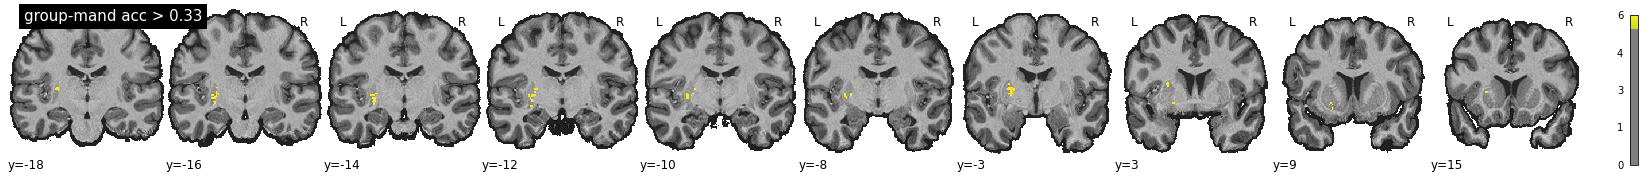

In [27]:
thr_acc = 0.33
group_label='mand'
#num_rois = len(roi_list)

#fig, axs = plt.subplots(nrows=round(num_rois/2), ncols=2, figsize=(12, num_rois), dpi=300)
#fig.suptitle('Mandarin-speaking searchlight accuracy > {}'.format(thr_acc))

sub_id = 'FLT08'
t1w_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/',
                           'sub-{}/anat'.format(sub_id),
                           'sub-{}_space-{}_desc-preproc_T1w.nii.gz'.format(sub_id, space_label))

#for mx, ax in enumerate(axs.T.flatten()):
mask_label = 'L-Put' #'gm-thr90_cond-tone'
print(mask_label)
group_img = os.path.join(deriv_dir, 'searchlight_group', 
                         'group-{}_mask-{}_searchlight_thr-{}.nii.gz'.format(group_label, mask_label, thr_acc))
#ax = plt.subplot(num_rois/2, 2, mx + 1)
display = plotting.plot_img(group_img, bg_img=t1w_fpath, 
                             title='group-{} acc > {}'.format(group_label, thr_acc),
                             #cmap='hot', 
                             threshold=5.5, 
                             vmin=0, vmax=6,
                             black_bg=False,
                             colorbar=True,
                             cbar_tick_format="%i",
                            display_mode='y',
                            cut_coords=[-18, -16, -14, -12, -10, -8, -3, 3, 9, 15],
                             #axes=ax
                          )
'''
group_label='nman'
#num_rois = len(roi_list)

#fig, axs = plt.subplots(nrows=round(num_rois/2), ncols=2, figsize=(12, num_rois), dpi=300)
#fig.suptitle('Mandarin-speaking searchlight accuracy > {}'.format(thr_acc))

sub_id = 'FLT08'
t1w_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/',
                           'sub-{}/anat'.format(sub_id),
                           'sub-{}_space-{}_desc-preproc_T1w.nii.gz'.format(sub_id, space_label))

#for mx, ax in enumerate(axs.T.flatten()):
mask_label = 'gm-thr90_cond-tone'
print(mask_label)
group_img = os.path.join(deriv_dir, 'searchlight_group', 
                         'group-{}_mask-{}_searchlight_thr-{}.nii.gz'.format(group_label, mask_label, thr_acc))
#ax = plt.subplot(num_rois/2, 2, mx + 1)
display = plotting.plot_img(group_img, bg_img=t1w_fpath, 
                             title='group-{} acc > {}'.format(group_label, thr_acc),
                             #cmap='hot', 
                             threshold=3.5, 
                             vmin=0, vmax=6,
                             black_bg=False,
                             colorbar=True,
                             cbar_tick_format="%i",
                             #axes=ax
                          )

'''
#fig.savefig('group-{}_searchlight_thr-{}.png'.format(group_label, thr_acc))

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/searchlight/sub-FLT01_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/anat/sub-FLT01_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


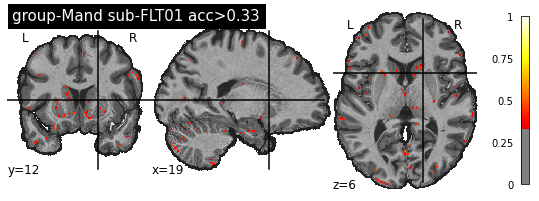

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT03_space-MNI152NLin2009cAsym/searchlight/sub-FLT03_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT03/anat/sub-FLT03_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


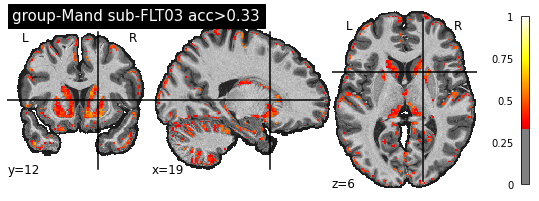

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT05_space-MNI152NLin2009cAsym/searchlight/sub-FLT05_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT05/anat/sub-FLT05_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


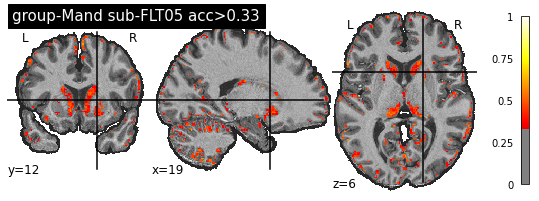

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT07_space-MNI152NLin2009cAsym/searchlight/sub-FLT07_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT07/anat/sub-FLT07_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


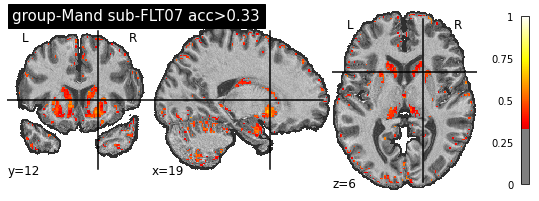

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-MNI152NLin2009cAsym/searchlight/sub-FLT08_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT08/anat/sub-FLT08_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


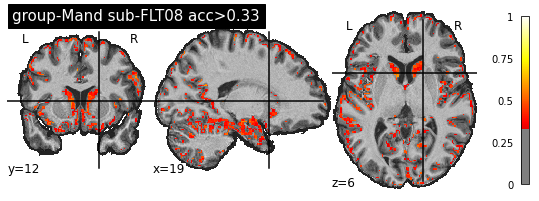

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT10_space-MNI152NLin2009cAsym/searchlight/sub-FLT10_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT10/anat/sub-FLT10_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


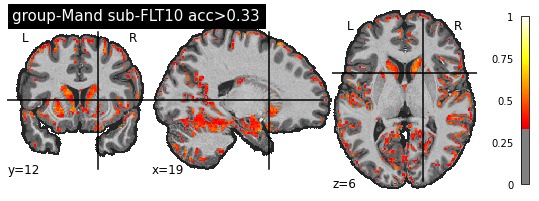

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT02_space-MNI152NLin2009cAsym/searchlight/sub-FLT02_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT02/anat/sub-FLT02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


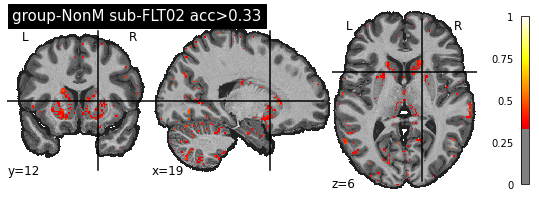

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-MNI152NLin2009cAsym/searchlight/sub-FLT04_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/anat/sub-FLT04_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


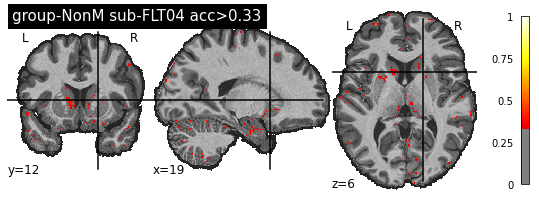

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT06_space-MNI152NLin2009cAsym/searchlight/sub-FLT06_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT06/anat/sub-FLT06_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


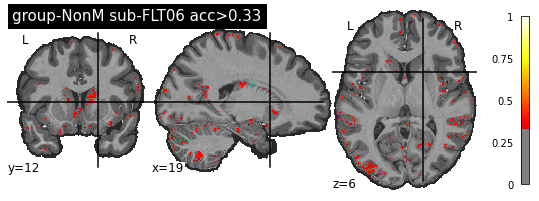

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT09_space-MNI152NLin2009cAsym/searchlight/sub-FLT09_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT09/anat/sub-FLT09_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


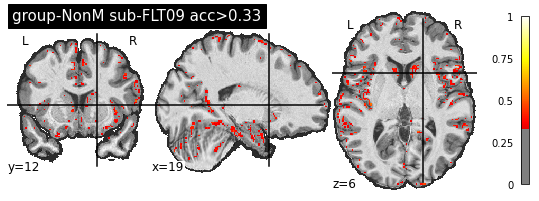

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT11_space-MNI152NLin2009cAsym/searchlight/sub-FLT11_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT11/anat/sub-FLT11_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


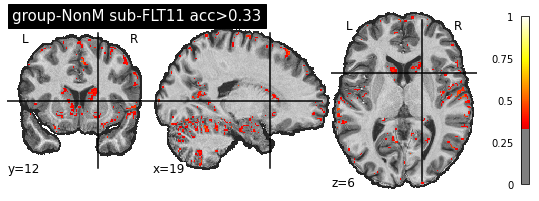

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT12_space-MNI152NLin2009cAsym/searchlight/sub-FLT12_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT12/anat/sub-FLT12_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


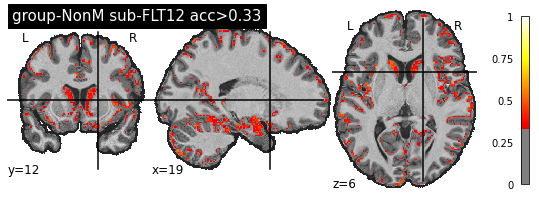

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT13_space-MNI152NLin2009cAsym/searchlight/sub-FLT13_space-MNI152NLin2009cAsym_mask-gm-thr90_cond-tone_searchlight.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT13/anat/sub-FLT13_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


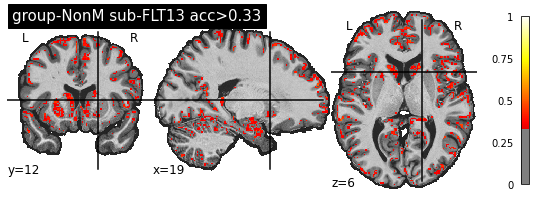

In [28]:
#fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(8,12), dpi=300)
#fig.suptitle('Participant whole brain searchlight accuracy')

thr_acc = 0.33

mand_i = 0
nonm_i = 0
for sx, sub_id in enumerate(sub_list):
    
    sub_map_fpath = os.path.join(deriv_dir,
                                 'sub-{}_space-{}/searchlight/'.format(sub_id, space_label),
                                 'sub-{}_space-{}_mask-gm-thr90_cond-tone_searchlight.nii.gz'.format(sub_id, space_label))
    t1w_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/',
                           'sub-{}/anat'.format(sub_id),
                           'sub-{}_space-{}_desc-preproc_T1w.nii.gz'.format(sub_id, space_label))
    print(sub_map_fpath)
    print(t1w_fpath)

    if sub_id in sub_list_mand:
        #plotting.show(ax=axes[mand_i,0])
        mand_i += 1
        group_id = 'Mand'
    elif sub_id in sub_list_nman:
        #plotting.show(ax=axes[nonm_i,1])
        nonm_i += 1
        group_id = 'NonM'
        
    '''
    display = plotting.plot_img_on_surf(sub_map_fpath,
                              surf_mesh='fsaverage',
                              views=['lateral', 'medial'],
                              hemispheres=['left', 'right'],
                              threshold=0.25,
                              colorbar=True)
    '''
    display = plotting.plot_img(sub_map_fpath, bg_img=t1w_fpath, 
                                title='group-{} sub-{} acc>{}'.format(group_id, sub_id, thr_acc),
                                cmap='hot', 
                                threshold=thr_acc, 
                                vmin=0, vmax=1,
                                black_bg=False,
                                colorbar=True,
                                cut_coords=[19,12,6],
                                #cbar_tick_format="%i",
                                #axes=ax,
                                )
    

    #display.ax_.set_title('%s – %s'%(sub_id, group_id));
    plotting.show()

## Train expert, test learner

In [27]:
import os
import numpy as np
from copy import copy
from glob import glob
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score


In [7]:
sub_list_mand = ['FLT03', 'FLT05', 'FLT07', 'FLT08', 'FLT10', ] # 'FLT01', 

sub_list_nman = ['FLT02', 'FLT04', 'FLT06', 'FLT09', 'FLT11', 'FLT12', 'FLT13', ]

sub_list = sub_list_mand + sub_list_nman
print(sub_list)

['FLT03', 'FLT05', 'FLT07', 'FLT08', 'FLT10', 'FLT02', 'FLT04', 'FLT06', 'FLT09', 'FLT11', 'FLT12', 'FLT13']


In [8]:
roi_list = ['L-Caud', 'L-Put', 'R-Caud', 'R-Put']

In [15]:
fwhm_sub = 1.50
space_label = 'MNI152NLin2009cAsym'
nilearn_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/',
                         'data_bids_noIntendedFor/derivatives/nilearn/')
deriv_dir = os.path.join(nilearn_dir, 'level-1_fwhm-1.50')


In [16]:
# training data
mand_data = []
for sub_id in sub_list_mand:
    nilearn_sub_dir = os.path.join(deriv_dir,
                                   'sub-%s_space-%s'%(sub_id, space_label))

    stat_maps = sorted(glob(nilearn_sub_dir+'/stimulus_per_run'+'/run*/*di*nii.gz')) # run-specific stimulus beta maps
    
    mand_data=mand_data+stat_maps

In [17]:
# test data
nman_data = []
for sub_id in sub_list_nman:
    nilearn_sub_dir = os.path.join(deriv_dir,
                                   'sub-%s_space-%s'%(sub_id, space_label))

    stat_maps = sorted(glob(nilearn_sub_dir+'/stimulus_per_run'+'/run*/*di*nii.gz')) # run-specific stimulus beta maps
    
    nman_data=nman_data+stat_maps

In [29]:
cv_list_tone = []
cv_list_talker = []
cv_list_null = []

sub_gen = 'FLT10'
for mask_descrip in roi_list:
    # define the mask for the region of interest
    print(mask_descrip)
    masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_gen, 'space-%s'%space_label, 'masks-dseg', )
    mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_gen, space_label, mask_descrip))
    
    # generating training data and labels
    print('training set length: ', len(mand_data))
    X_train, train_masker = mask_fmri(mand_data, mask_fpath, fwhm_sub)
    train_conditions_tone, train_conditions_talker, train_conditions_all, train_conditions_shuffled = create_labels(mand_data)
    y_train = copy(train_conditions_tone)
          
    print('initializing classifier')
    clf = svm.SVC(decision_function_shape='ovo').fit(X_train, y_train)
    
    print('cross-validating the training set')
    cv_scores = cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=4))
    print('cross-validation score = ', cv_scores.mean())

    for sub_id in sub_list_nman:
        print(sub_id)
        # generating test data and labels
        nilearn_sub_dir = os.path.join(deriv_dir, 'sub-%s_space-%s'%(sub_id, space_label))
        
        for rx, run_dir in enumerate(sorted(glob(nilearn_sub_dir+'/stimulus_per_run'+'/run*'))):
            run_label = os.path.basename(run_dir)
            print(run_label)
            stat_maps = sorted(glob(run_dir+'/*di*nii.gz'))

            masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 'masks-dseg', )
            mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))

            print('test set length: ', len(stat_maps))
            X_test, test_masker = mask_fmri(stat_maps, mask_fpath, fwhm_sub)
            test_conditions_tone, test_conditions_talker, test_conditions_all, test_conditions_shuffled = create_labels(stat_maps)
            y_test = copy(test_conditions_tone)

            # Run classifier
            y_pred = clf.predict(X_test)

            clf_acc = accuracy_score(y_test, y_pred)
            print('sub-{} run-{} mask-{} accuracy: '.format(sub_id, run_label, mask_descrip), clf_acc)

            # append subject cv scores to overall list
            cv_list_tone.append(clf_acc)


L-Caud
training set length:  480
initializing classifier
cross-validating the training set
cross-validation score =  0.3
FLT02
run00
test set length:  16
sub-FLT02 run-run00 mask-L-Caud accuracy:  0.3125
run01
test set length:  16
sub-FLT02 run-run01 mask-L-Caud accuracy:  0.3125
run02
test set length:  16
sub-FLT02 run-run02 mask-L-Caud accuracy:  0.1875
run03
test set length:  16
sub-FLT02 run-run03 mask-L-Caud accuracy:  0.1875
run04
test set length:  16
sub-FLT02 run-run04 mask-L-Caud accuracy:  0.1875
run05
test set length:  16
sub-FLT02 run-run05 mask-L-Caud accuracy:  0.3125
FLT04
run00
test set length:  16
sub-FLT04 run-run00 mask-L-Caud accuracy:  0.25
run01
test set length:  16
sub-FLT04 run-run01 mask-L-Caud accuracy:  0.125
run02
test set length:  16
sub-FLT04 run-run02 mask-L-Caud accuracy:  0.25
run03
test set length:  16
sub-FLT04 run-run03 mask-L-Caud accuracy:  0.3125
run04
test set length:  16
sub-FLT04 run-run04 mask-L-Caud accuracy:  0.1875
run05
test set length:  1

## Extract voxels from an ROI

In [47]:
#roi_list = list(roi_dict_MNI_dseg.keys()) # roi_dict_MNI_sg_subcort

roi_list = ['L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp',
            'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', ]

fwhm_sub = 0.
space_label = 'MNI152NLin2009cAsym'
stat_descrip = 'beta'

print(roi_list)

['L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp']


In [46]:
sub_list = ['FLT11']

#### Run-specific

In [ ]:
for sub_id in sub_list:
    print(sub_id)

    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                   'level-1_fwhm-%.02f'%fwhm_sub, 
                                   'sub-%s_space-%s'%(sub_id, space_label), 
                                   'trial_models', #'run-all',
                                  )
    
    out_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                           'level-1_fwhm-%.02f'%fwhm_sub,
                           'masked_statmaps',
                           sub_id, 'statmaps_masked')
    os.makedirs(out_dir, exist_ok=True)
    
    for mx, mask_descrip in enumerate(roi_list):
        print(mask_descrip)
        # define the mask for the region of interest
        masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 'masks-dseg')#, 'masks-aparc' 'masks-subcort-aud'
        mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
        
        print(sorted(glob(nilearn_sub_dir+'/run*')))
        # run-specific stimulus stat maps
        for rx, run_dir in enumerate(sorted(glob(nilearn_sub_dir+'/run*'))):
            stat_maps = sorted(glob(run_dir+'/*di*map-{}.nii.gz'.format(stat_descrip))) 
            print('# of stat maps: ', len(stat_maps))    

            conditions_all = ['_'.join(os.path.basename(x).split('_')[5:7]) for x in (stat_maps)]

            for sx, stat_fpath in enumerate(stat_maps):
                cond_label = conditions_all[sx]
                print(cond_label)

                print('masking ', mask_descrip)
                fmri_masked, masker = mask_fmri(stat_fpath, mask_fpath, fwhm_sub)

                # save out
                out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s_run-%02d_cond-%s_map-%s.csv'%(sub_id, space_label, mask_descrip, rx, cond_label, stat_descrip))
                np.savetxt(out_fpath, fmri_masked)
                print('ROI-masked {}-stats saved to '.format(stat_descrip), out_fpath)

                masked_out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s_run-%02d_cond-%s_map-%s.nii.gz'%(sub_id, space_label, mask_descrip,  rx, cond_label, stat_descrip))
                masked_img = masker.inverse_transform(fmri_masked)
                nib.save(masked_img, masked_out_fpath)

#### Across runs

In [49]:
for sub_id in sub_list:
    print(sub_id)

    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                   'level-1_fwhm-%.02f'%fwhm_sub, 
                                   'sub-%s_space-%s'%(sub_id, space_label), 
                                   'run-all',
                                  )
    
    out_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                           'level-1_fwhm-%.02f'%fwhm_sub,
                           'masked_statmaps',
                           sub_id, 'statmaps_masked', 'run-all')
    os.makedirs(out_dir, exist_ok=True)
    
    masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 
                             'masks-dseg')#, 'masks-aparc', 'masks-subcort-aud', 'masks-dseg'
    for mx, mask_descrip in enumerate(roi_list):
        print(mask_descrip)
        # define the mask for the region of interest
        mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
                
        stat_maps = sorted(glob(nilearn_sub_dir+'/*di*map-{}.nii.gz'.format(stat_descrip))) 
        print('# of stat maps: ', len(stat_maps))    

        conditions_all = ['_'.join(os.path.basename(x).split('_')[5:7]) for x in (stat_maps)]

        for sx, stat_fpath in enumerate(stat_maps):
            cond_label = conditions_all[sx]
            print(cond_label)

            print('masking ', mask_descrip)
            fmri_masked, masker = mask_fmri(stat_fpath, mask_fpath, fwhm_sub)

            # save out
            out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s_cond-%s_map-%s.csv'%(sub_id, space_label, mask_descrip, cond_label, stat_descrip))
            np.savetxt(out_fpath, fmri_masked)
            print('ROI-masked {}-stats saved to '.format(stat_descrip), out_fpath)

            masked_out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s_cond-%s_map-%s.nii.gz'%(sub_id, space_label, mask_descrip, cond_label, stat_descrip))
            masked_img = masker.inverse_transform(fmri_masked)
            nib.save(masked_img, masked_out_fpath)

FLT11
L-HG
# of stat maps:  16
di1_aN
masking  L-HG
ROI-masked beta-stats saved to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-0.00/masked_statmaps/FLT11/statmaps_masked/run-all/sub-FLT11_space-MNI152NLin2009cAsym_mask-L-HG_cond-di1_aN_map-beta.csv
di1_bN
masking  L-HG
ROI-masked beta-stats saved to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-0.00/masked_statmaps/FLT11/statmaps_masked/run-all/sub-FLT11_space-MNI152NLin2009cAsym_mask-L-HG_cond-di1_bN_map-beta.csv
di1_hN
masking  L-HG
ROI-masked beta-stats saved to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-0.00/masked_statmaps/FLT11/statmaps_masked/run-all/sub-FLT11_space-MNI152NLin2009cAsym_mask-L-HG_cond-di1_hN_map-beta.csv
di1_iN
masking  L-HG
ROI-masked beta-stats saved to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-0.00/masked

#### check masks

In [1]:
from nilearn import plotting
from nilearn.image import new_img_like
from nilearn.image import math_img, threshold_img
import matplotlib.pyplot as plt

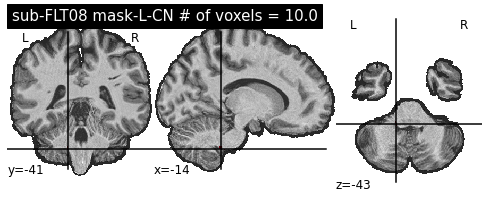

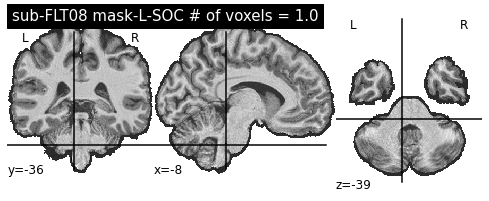

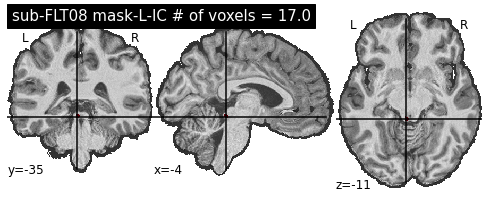

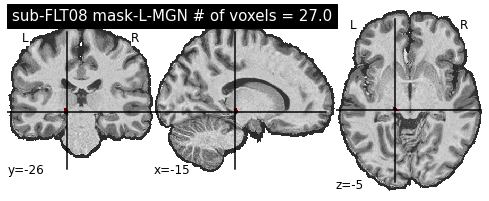

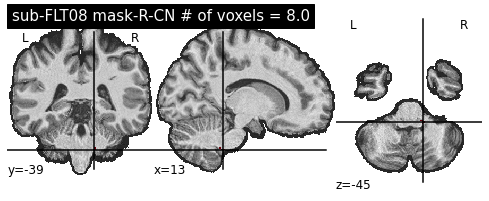

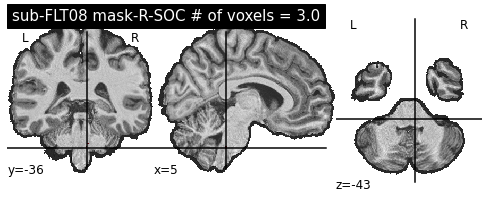

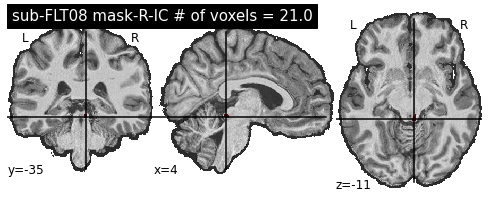

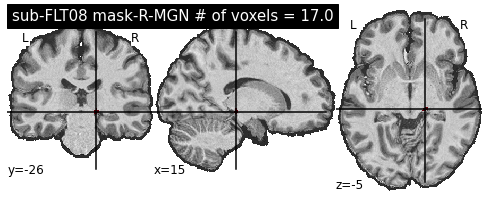

In [24]:
space_label = 'MNI152NLin2009cAsym'
roi_list = list(roi_dict.keys())

for sub_id in ['FLT08']: #sub_list:
    t1w_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/',
                           'sub-{}/anat'.format(sub_id),
                           'sub-{}_space-{}_desc-preproc_T1w.nii.gz'.format(sub_id, space_label))
    
    masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 'masks-subcort-aud')#, 'masks-aparc' 'masks-subcort-aud'
    for mx, mask_descrip in enumerate(roi_list):
        # define the mask for the region of interest
        mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
        
        mask_data = nib.load(mask_fpath).get_fdata()
        num_voxels = sum(sum(sum(mask_data)))

        display = plotting.plot_img(mask_fpath, bg_img=t1w_fpath, 
                                    title='sub-{} mask-{} # of voxels = {}'.format(sub_id, mask_descrip, num_voxels),
                                    threshold=0.5,
                                    vmin=0.5,
                                    cmap='Reds', 
                                    black_bg=False,
                                    #colorbar=True,
                                    )
        plotting.show()